# Markov Regime Switching Regression Model
_______

## In probability theory, a Markov model is a stochastic model used to model pseudo-randomly changing systems. It is assumed that future states depend only on the current state, not on the events that occurred before it. 
#### Source: [Wikipedia](https://en.wikipedia.org/wiki/Markov_model#Introduction)



In [263]:
''' 
Source:

https://www.statsmodels.org/stable/generated/statsmodels.tsa.regime_switching.markov_regression.MarkovRegression.html

https://www.statsmodels.org/devel/examples/notebooks/generated/markov_regression.html

'''

' \nSource:\n\nhttps://www.statsmodels.org/stable/generated/statsmodels.tsa.regime_switching.markov_regression.MarkovRegression.html\n\nhttps://www.statsmodels.org/devel/examples/notebooks/generated/markov_regression.html\n\n'

In [203]:
# Import libraries
import numpy as np
import datetime
import warnings
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.regime_switching import markov_regression

%matplotlib inline

In [204]:
# Read in S&P price (Adj Close) data from csv file (Adj Close prices pulled from the yahoo_historical.ipynb)
stock_prices = pd.read_csv("/Users/draganbogatic/Documents/Fin_Tech/stock-evaluation/Resources/stock_historical_prices.csv", parse_dates=True, index_col='Date')

#We will use daily returns from 2018-2021
stock_prices = stock_prices.loc['2018':'2021']
stock_prices.head()

,Adj Close
Date,
2018-01-02,253.283142
2018-01-03,254.885162
2018-01-04,255.959488
2018-01-05,257.665283
2018-01-08,258.136414


In [205]:
# Calculate daily return
stock_prices["Return"] = stock_prices['Adj Close'].pct_change()
stock_return = stock_prices["Return"]
stock_return = stock_return.dropna()
stock_return = stock_return.asfreq('B')
stock_return = stock_return.dropna()
stock_return.head()

Date
2018-01-03    0.006325
2018-01-04    0.004215
2018-01-05    0.006664
2018-01-08    0.001828
2018-01-09    0.002263
Name: Return, dtype: float64

<AxesSubplot:title={'center':'Daily Returns'}, xlabel='Date'>

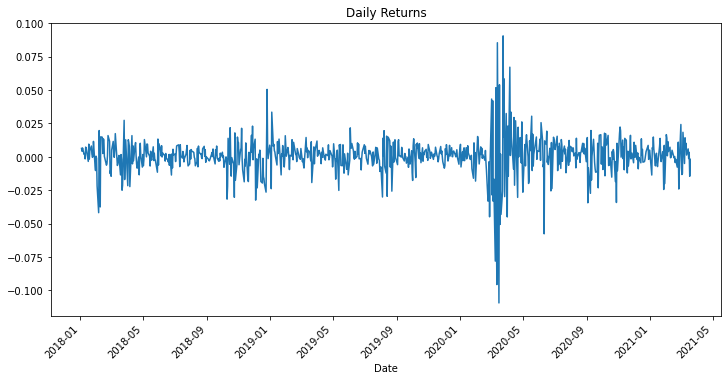

In [206]:
# Plot daily returns
stock_return.plot(title='Daily Returns',figsize=(12,6),rot=45)

In [207]:
# Apply the Augmented Dickey-Fuller test to determine if the above is stationary
adfuller(stock_return)

(-8.411118338972967,
 2.1025534743926435e-13,
 8,
 799,
 {'1%': -3.4385608049885876,
  '5%': -2.865164107438179,
  '10%': -2.5686998068142124},
 -4573.818160660616)

In [208]:
# The series is stationary (the p-value of the ADFuller test is close to 0) and the model can be fit on it.

In [209]:
# Fit the model (we use switching variance in the model, 2 regimes - standard and high, daily stock return, no trend)
mod_high_regime = sm.tsa.MarkovRegression(stock_return, k_regimes=2, trend='nc', switching_variance=True)
res_high_regime = mod_high_regime.fit()
res_high_regime.summary()

/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 Return   No. Observations:                  808
Model:               MarkovRegression   Log Likelihood                2540.596
Date:                Thu, 15 Apr 2021   AIC                          -5073.191
Time:                        20:44:05   BIC                          -5054.413
Sample:                             0   HQIC                         -5065.981
                                - 808                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.407e-05    3.6e-06     12.236      0.000     3.7e-05    5.11e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0006   7.07e-05      8.425      0.000       0.000       0.001
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9736      0.009    111.087      0.000       0.956       0.991
p[1->0]        0.0687      0.025      2.760      0.006       0.020       0.117
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<AxesSubplot:title={'center':'Probability of being in the high regime'}, xlabel='Date'>

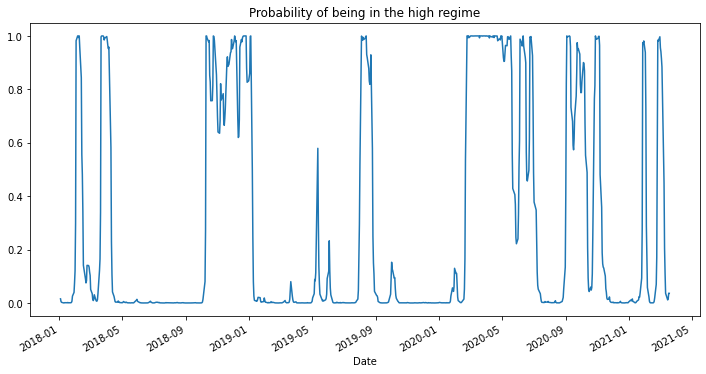

In [210]:
# Plot high regime
res_high_regime.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the high regime', figsize=(12,6))

In [211]:
# The above graph shows that Covid-19 2020 year was the year of high regime and high return volatility due to global crisis as well as temporary easing towards the end of that year due to probably trillions of dollars in government stimulus.

In [212]:
# Calculate the duration of regimes
print(res_high_regime.expected_durations)

[37.88183768 14.5540011 ]


In [213]:
# Low regime will last approx. 37 days and high regime 14 days (the way I interpret these results is that low regime is the period of low daily return volatility and high regime is the period of high return volatility)

<AxesSubplot:title={'center':'SPY Actual Daily Returns'}, xlabel='Date'>

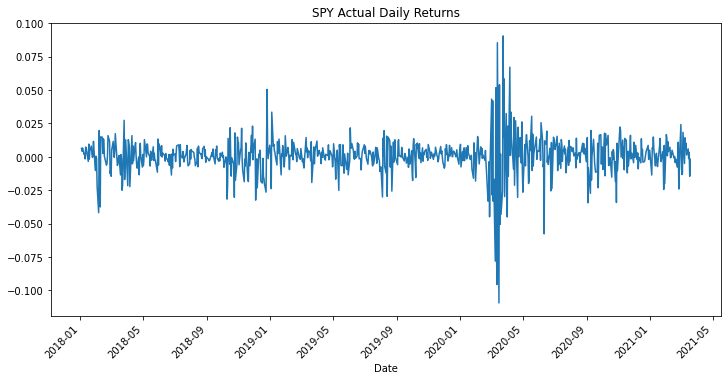

In [214]:
# Plot actual daily returns
actual_return = stock_return.plot(title='SPY Actual Daily Returns',figsize=(12,6),rot=45)
actual_return

In [215]:
# Modify model to include lagged return data
mod_high_regime_2 = sm.tsa.MarkovRegression(stock_return.iloc[1:],k_regimes=2, exog=stock_return.iloc[:-1])
res_high_regime_2 = mod_high_regime_2.fit()
res_high_regime_2.summary()

/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 Return   No. Observations:                  807
Model:               MarkovRegression   Log Likelihood                2382.866
Date:                Thu, 15 Apr 2021   AIC                          -4751.732
Time:                        20:44:06   BIC                          -4718.879
Sample:                             0   HQIC                         -4739.117
                                - 807                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.934      0.350      -0.002       0.001
x1             0.2957      0.088      3.358      0.001       0.123       0.468
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.036      0.002       0.001       0.005
x1            -0.6968      0.071     -9.817      0.000      -0.836      -0.558
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   7.56e-06     18.279      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.6329      0.152      4.166      0.000       0.335       0.931
p[1->0]        0.5913      0.090      6.550      0.000       0.414       0.768
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<AxesSubplot:title={'center':'Probability of being in the high regime'}, xlabel='Date'>

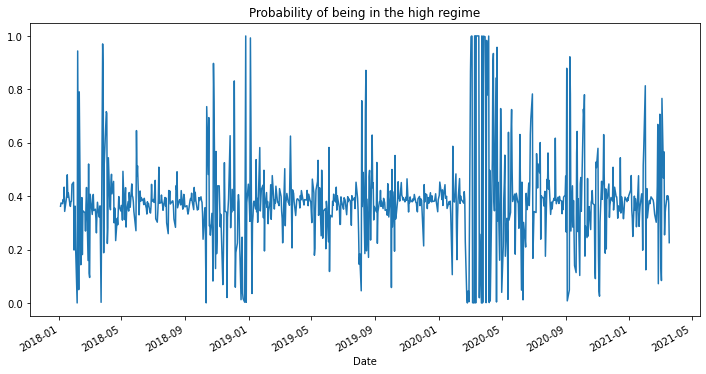

In [216]:
res_high_regime_2.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the high regime', figsize=(12,6))

In [217]:
print(res_high_regime_2.expected_durations)

[2.72386415 1.69113486]


In [218]:
# Lagged returns model is better fit than the previous model (lower AIC and BIC scores). It shows that during the analyzed time period low regime will persist for approx. 3 days while high regime will persist for appox. 2 days. 

In [219]:
prediction = res_high_regime_2.predict()

In [220]:
# Add predicted daily return to dataframe
stock_prices["Return"] = stock_prices['Adj Close'].pct_change()
stock_prices
stock_prices['Predicted'] = prediction
stock_prices.dropna()

,Adj Close,Return,Predicted
Date,,,
2018-01-04,255.959488,0.004215,0.000140
2018-01-05,257.665283,0.006664,0.000266
2018-01-08,258.136414,0.001828,0.000089
2018-01-09,258.720703,0.002263,0.000469
2018-01-10,258.324890,-0.001530,0.000423
...,...,...,...
2021-03-15,395.115906,0.005964,0.000544
2021-03-16,394.617523,-0.001261,0.000099
2021-03-17,395.963135,0.003410,0.000806


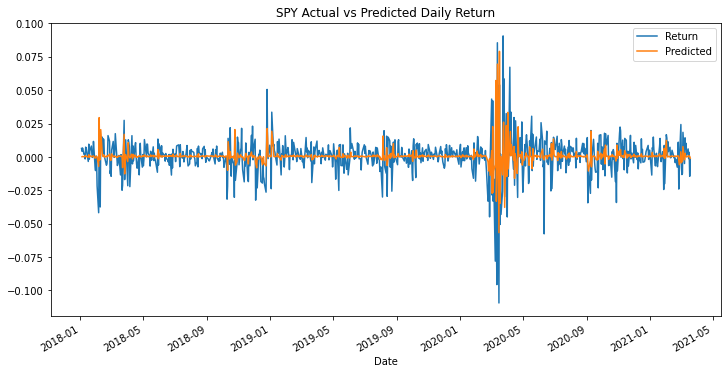

In [221]:
combined = stock_prices[['Return','Predicted']].plot(title='SPY Actual vs Predicted Daily Return', figsize=(12,6))

In [222]:
# The above graph suggests that the model is able to predict extreme regime shifts for the analyzed period. These are periods of high return volatility. It recognizes 2020 as the year of extreme volatility due to world Covid-19 crisis.

In [223]:
stock_prices.describe()

,Adj Close,Return,Predicted
count,809.000000,808.000000,807.000000
mean,292.754491,0.000633,0.000626
std,39.085341,0.014148,0.006687
min,219.431061,-0.109424,-0.056772
25%,263.055695,-0.003935,0.000025
50%,280.477051,0.001116,0.000390
75%,317.116211,0.006880,0.000785
max,395.963135,0.090603,0.079050


# Predicting the market volatility and Markov regime shifts using VXX ETF as a proxy for market volatility

In [270]:
# Read in VIX price (Adj Close) data from csv file (Adj Close prices pulled from the yahoo_historical.ipynb)
vix_prices = pd.read_csv("/Users/draganbogatic/Documents/Fin_Tech/stock-evaluation/Resources/VXX_stock_historical_prices.csv", parse_dates=True, index_col='Date')

#We will use daily returns from 2018-2021
vix_prices = vix_prices.loc['2018':'2021']
vix_prices = vix_prices.dropna()
vix_prices.head()

,Adj Close
Date,
2018-01-25,27.660000
2018-01-26,27.660000
2018-01-29,29.580000
2018-01-30,30.549999
2018-01-31,30.650000


In [271]:
# Calculate daily return
vix_prices["Return"] = vix_prices['Adj Close'].pct_change()
vix_return = vix_prices["Return"]
vix_return = vix_return.asfreq('S')
vix_return = vix_return.dropna()
vix_return.head()

Date
2018-01-26    0.000000
2018-01-29    0.069414
2018-01-30    0.032792
2018-01-31    0.003273
2018-02-01   -0.050343
Name: Return, dtype: float64

<AxesSubplot:title={'center':'VXX Daily Returns'}, xlabel='Date'>

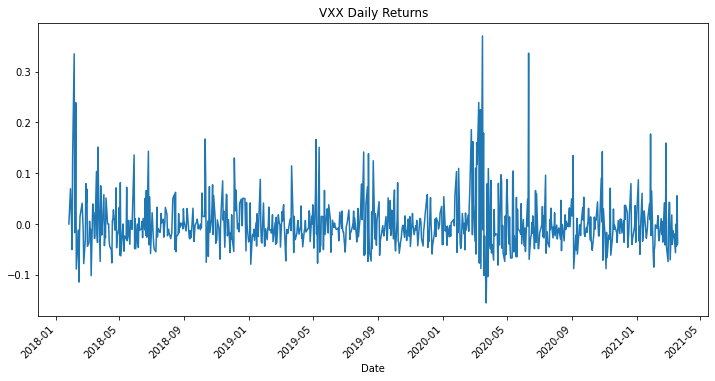

In [272]:
# Plot daily returns
vix_return.plot(title='VXX Daily Returns',figsize=(12,6),rot=45)

In [273]:
# Modify model to include lagged return data
mod_high_regime = sm.tsa.MarkovRegression(vix_return.iloc[1:],k_regimes=2, exog=vix_return.iloc[:-1])
res_high_regime = mod_high_regime.fit()
res_high_regime.summary()

/Users/draganbogatic/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 Return   No. Observations:                  791
Model:               MarkovRegression   Log Likelihood                1338.397
Date:                Thu, 15 Apr 2021   AIC                          -2662.794
Time:                        21:08:05   BIC                          -2630.081
Sample:                             0   HQIC                         -2650.220
                                - 791                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1645      0.011     14.810      0.000       0.143       0.186
x1             0.1020      0.237      0.431      0.667      -0.362       0.566
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0069      0.002     -4.533      0.000      -0.010      -0.004
x1            -0.0917      0.037     -2.464      0.014      -0.165      -0.019
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0015   8.28e-05     17.742      0.000       0.001       0.002
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.1606      0.085      1.880      0.060      -0.007       0.328
p[1->0]        0.0366      0.008      4.636      0.000       0.021       0.052
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [274]:
print(res_high_regime.expected_durations)

[ 1.19127299 27.30286974]


In [229]:
# Duration suggests that low regime will persist for approx 2 days and high regime for 28 days suggesting an extended timeframe of high market volatility. We also need to keep in mind that VIX ETFs are not a perfect proxy for VIX fear index and they (ETFs that trade VIX) are volatilie in nature because of the way they operate. Need to evaluate more. 

<AxesSubplot:title={'center':'Probability of being in the high regime'}, xlabel='Date'>

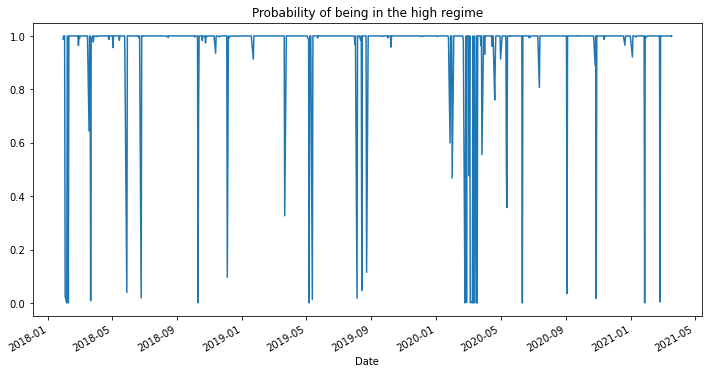

In [275]:
res_high_regime.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the high regime', figsize=(12,6))

In [276]:
prediction = res_high_regime.predict()

In [277]:
# Add predicted daily return to dataframe
vix_prices["Return"] = vix_prices['Adj Close'].pct_change()
vix_prices['Predicted'] = prediction
vix_prices.dropna()

,Adj Close,Return,Predicted
Date,,,
2018-01-29,29.580000,0.069414,-0.004765
2018-01-30,30.549999,0.032792,-0.013267
2018-01-31,30.650000,0.003273,-0.009926
2018-02-01,29.107000,-0.050343,-0.007218
2018-02-02,32.849998,0.128594,0.155549
...,...,...,...
2021-03-15,13.160000,-0.056631,-0.005176
2021-03-16,13.160000,0.000000,-0.001721
2021-03-17,12.590000,-0.043313,-0.006918


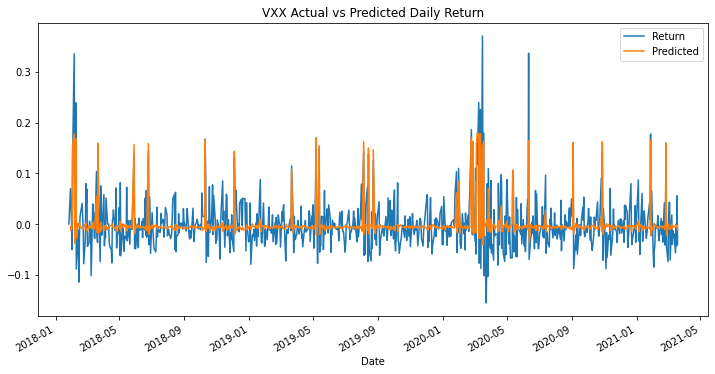

In [279]:
combined = vix_prices[['Return','Predicted']].plot(title='VXX Actual vs Predicted Daily Return', figsize=(12,6))

In [262]:
vix_prices.describe()

,Adj Close,Return,Predicted
count,718.000000,717.000000,716.000000
mean,7345.643693,0.000143,0.000161
std,1951.340981,0.033731,0.006819
min,4952.379883,-0.366015,-0.035240
25%,5904.759766,-0.014927,-0.000916
50%,6893.419922,0.000000,-0.000273
75%,7700.000000,0.014925,0.000498
max,12863.299805,0.166667,0.078512


In [235]:
# VIX ETF predicted values underestimate downside volatility and max potential daily loss.